# Anomaly detection k means

In [193]:
import pandas as pd
import numpy as np

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [194]:
%run anomaly_detection_common.ipynb

## Loading dataset

In [195]:
dataset = ATSFDataset().load()
data_df = dataset.get_df()
data_df.head()

,timestamp,value_f,value_c,hours,daylight,day_of_the_week,week_day,time_epoch,categories
0,2013-07-04 00:00:00,69.880835,21.044908,0,0,3,1,13728960,2
1,2013-07-04 01:00:00,71.220227,21.789015,1,0,3,1,13728996,2
2,2013-07-04 02:00:00,70.877805,21.598781,2,0,3,1,13729032,2
3,2013-07-04 03:00:00,68.959400,20.533000,3,0,3,1,13729068,2
4,2013-07-04 04:00:00,69.283551,20.713084,4,0,3,1,13729104,2


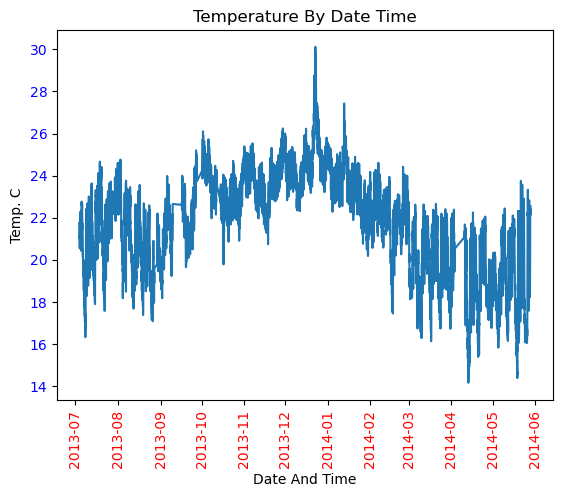

In [196]:
dataset.plot()

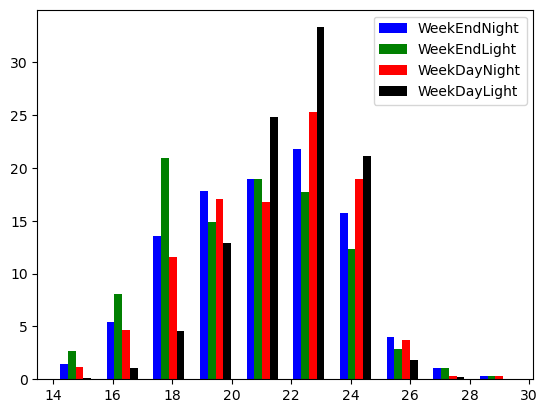

In [197]:
dataset.plot_categories()

In [198]:
# Take useful feature and standardize them
features = [ATSFDataset.Columns.VALUE_C, \
                    ATSFDataset.Columns.HOURS, \
                    ATSFDataset.Columns.DAYLIGHT, \
                    ATSFDataset.Columns.DAY_OF_THE_WEEK, \
                    ATSFDataset.Columns.WEEK_DAY]

features_df = data_df[features]
features_df.head()

,value_c,hours,daylight,day_of_the_week,week_day
0,21.044908,0,0,3,1
1,21.789015,1,0,3,1
2,21.598781,2,0,3,1
3,20.533000,3,0,3,1
4,20.713084,4,0,3,1


In [199]:
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(features_df)
scaled_df = pd.DataFrame(np_scaled)
scaled_df.head()

,0,1,2,3,4
0,-0.320586,-1.661537,-1.414798,0.005769,0.62132
1,-0.005228,-1.517172,-1.414798,0.005769,0.62132
2,-0.085851,-1.372807,-1.414798,0.005769,0.62132
3,-0.537536,-1.228442,-1.414798,0.005769,0.62132
4,-0.461215,-1.084077,-1.414798,0.005769,0.62132


In [200]:
# reduce to 2 importants features
pca = PCA(n_components=2)
np_reduced = pca.fit_transform(scaled_df)
reduced_df = pd.DataFrame(np_reduced)
reduced_df.head()

,0,1
0,0.089870,2.238824
1,-0.012781,2.101394
2,-0.012707,2.012200
3,0.083627,1.968208
4,0.042987,1.859896


In [201]:
# standardize these 2 new features
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(reduced_df)
train_df = pd.DataFrame(np_scaled)
train_df.head()

,0,1
0,0.066191,1.755363
1,-0.009413,1.647609
2,-0.009359,1.577677
3,0.061592,1.543184
4,0.031660,1.458262


In [202]:
# calculate with different number of centroids to see the loss plot (elbow method)
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i, n_init='auto').fit(train_df) for i in n_cluster]
scores = [kmeans[i].score(train_df) for i in range(len(kmeans))]

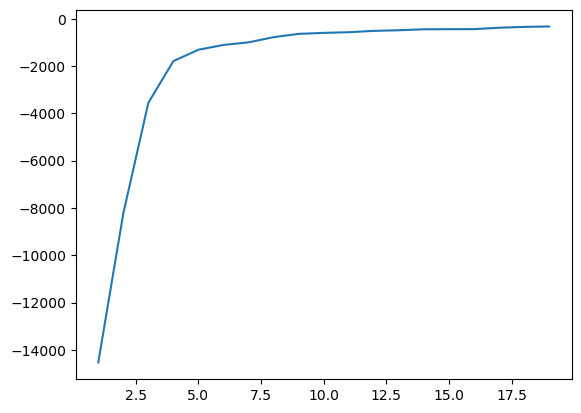

In [203]:
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [204]:
# Not clear for me, I choose 15 centroids arbitrarily and add these data to the central dataframe
cluster_count = 14
kmeans_results_df = pd.DataFrame(columns=['cluster', 'feature1', 'feature2'])

kmeans_results_df['cluster'] = kmeans[cluster_count].predict(train_df)
kmeans_results_df['feature1'] = train_df[0]
kmeans_results_df['feature2'] = train_df[1]
kmeans_results_df.head()

,cluster,feature1,feature2
0,1,0.066191,1.755363
1,1,-0.009413,1.647609
2,1,-0.009359,1.577677
3,1,0.061592,1.543184
4,1,0.031660,1.458262


In [205]:
colors = {
    0:'red', 
    1:'blue', 
    2:'green', 
    3:'pink', 
    4:'black', 
    5:'orange', 
    6:'cyan', 
    7:'yellow', 
    8:'brown', 
    9:'purple', 
    10:'white', 
    11: 'grey', 
    12:'lightblue', 
    13:'lightgreen', 
    14: 'darkgrey'
}

In [206]:
cluster_sizes = kmeans_results_df['cluster'].value_counts()
cluster_sizes.sort_index(inplace=True)

In [207]:
clusters_df = pd.DataFrame(columns=['cluster_no', 'cluster_size', 'cluster_color'])
clusters_df['cluster_no'] = cluster_sizes.index.values
clusters_df['cluster_size'] = cluster_sizes.values
clusters_df['cluster_color'] = list(colors.values())

clusters_df

,cluster_no,cluster_size,cluster_color
0,0,426,red
1,1,455,blue
2,2,758,green
3,3,421,pink
4,4,596,black
5,5,458,orange
6,6,332,cyan
7,7,354,yellow
8,8,670,brown
9,9,452,purple


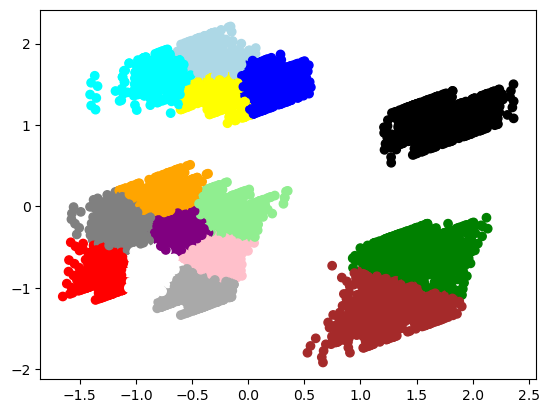

In [208]:
#plot the different clusters with the 2 main features
fig, ax = plt.subplots()
ax.scatter(kmeans_results_df['feature1'], \
           kmeans_results_df['feature2'], \
           c=kmeans_results_df["cluster"].apply(lambda x: colors[x]))
plt.show()

In [209]:
def get_distance_by_point(df, model):
    
    df_len = len(df)
    distance = pd.Series()
    for i in range(0, df_len):
        point_coord = np.array(df.loc[i])
        centroid_coord = model.cluster_centers_[model.labels_[i]-1]
        distance.at[i] = np.linalg.norm(point_coord-centroid_coord)
    return distance

In [211]:
outliers_fraction = 0.01
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = get_distance_by_point(train_df, kmeans[14])
number_of_outliers = int(outliers_fraction * len(distance))
threshold = distance.nlargest(number_of_outliers).min()
kmeans_results_df['is_anomaly'] = (distance >= threshold).astype(int)

#kmeans_results_df[kmeans_results_df['anomaly'] == 1]
kmeans_results_df.head()

C:\Users\inahshan\AppData\Local\Temp\ipykernel_53592\1070417806.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  distance = pd.Series()


,cluster,feature1,feature2,is_anomaly
0,1,0.066191,1.755363,0
1,1,-0.009413,1.647609,0
2,1,-0.009359,1.577677,0
3,1,0.061592,1.543184,0
4,1,0.031660,1.458262,0


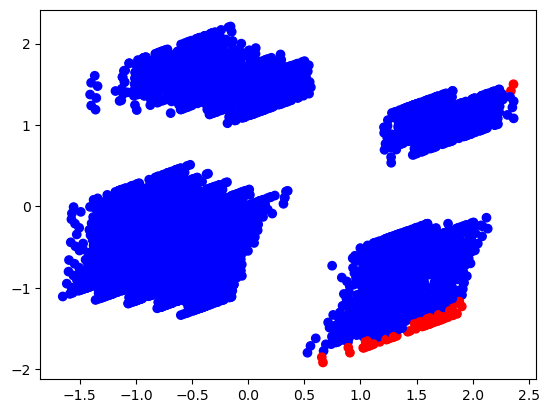

In [214]:
# visualisation of anomaly with cluster view
fig, ax = plt.subplots()
colors = {0:'blue', 1:'red'}
ax.scatter(kmeans_results_df['feature1'], \
           kmeans_results_df['feature2'], \
           c=kmeans_results_df["is_anomaly"].apply(lambda x: colors[x]))
plt.show()

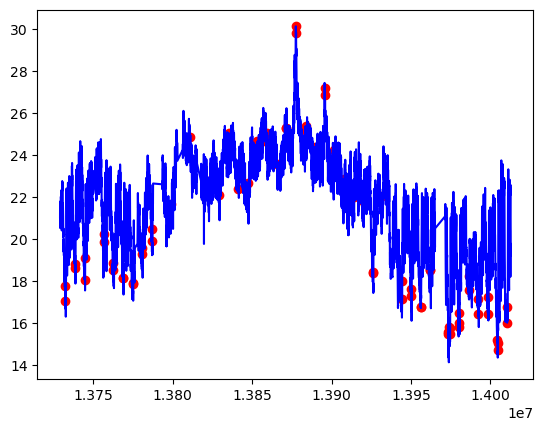

In [217]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = data_df.loc[kmeans_results_df['is_anomaly'] == 1, ['time_epoch', 'value_c']] #anomaly

ax.plot(data_df['time_epoch'], data_df['value_c'], color='blue')
ax.scatter(a['time_epoch'],a['value_c'], color='red')
plt.show()

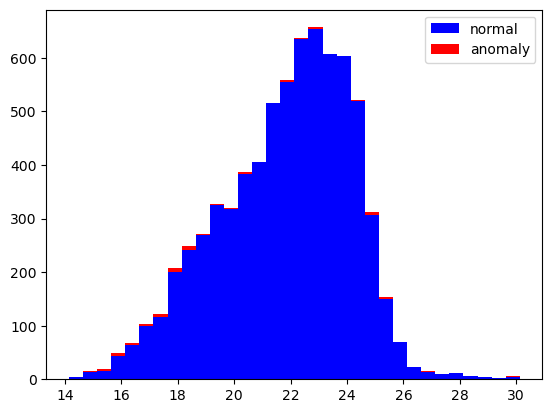

In [218]:
# visualisation of anomaly with temperature repartition (viz 2)
a = data_df.loc[kmeans_results_df['is_anomaly'] == 0, 'value_c']
b = data_df.loc[kmeans_results_df['is_anomaly'] == 1, 'value_c']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()